# This is a pipeline to visualize and analyze the results of CellProfiler on RNAprobe experiments done for D1 and D2 probes

In [1]:
# Import stuff
%load_ext autoreload
%autoreload 2
import os
from utils import data_reader
from utils import plot_utils
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
#from ggplot import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random

In [2]:
# Select the path where the data is (the output of CellProfiler)
CPoutput_path = '/mnt/c/Users/herny/Desktop/SWC/Data/Microscopy_Data/Histology_of_tail_lesions/DRD1KO/Cell_profiler_output/'

In [3]:
# Import the data
df = data_reader.D1D2_data_reader(CPoutput_path)

In [4]:
# Rename channels
df = df.rename(columns={"Children_FinalDots_C2_Count": "drd2_count",
                        "Children_FinalDots_C3_Count": "drd1_count"})

***
### Sanity checks on the data
***

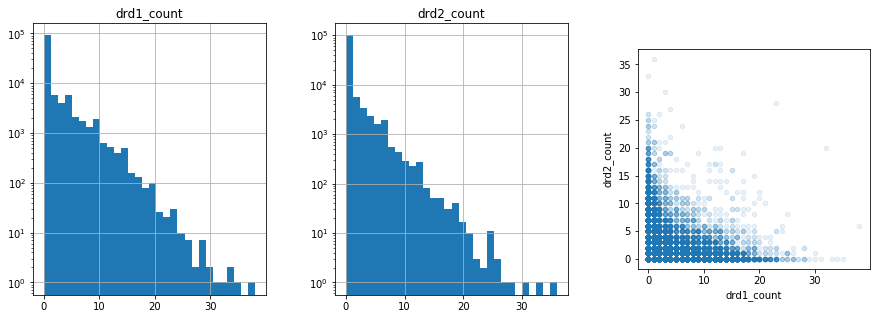

In [5]:
# plot histograms of counts for all the cells
channels = ["drd1_count", "drd2_count"]
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
axArr = [ax1, ax2]
i = 0
for axis in axArr:
    df.hist(channels[i], ax = axis, bins=30)
    #sns.distplot(df[channels[i]], ax = axis)
    axis.set_yscale("log")
    #axis.set_ylim(0,1000)
    axis.set_title(channels[i])
    i+=1
df.plot.scatter(channels[0],channels[1], ax = ax3, alpha = 0.1)
ax3.set_aspect('equal')

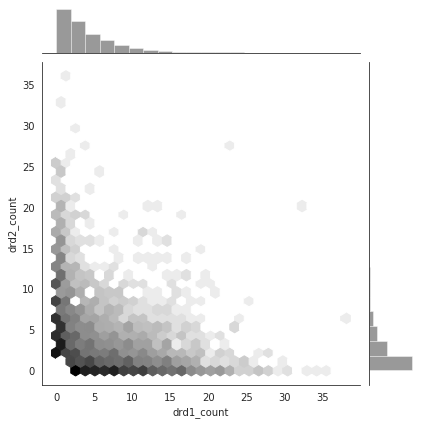

In [6]:
# focus on those cells above a certain number of dots
%matplotlib inline
thr = 1
above_thr = np.logical_or(df[channels[0]] > thr, df[channels[1]] > thr)
pal = sns.cubehelix_palette(light=1, as_cmap=True)
with sns.axes_style("white"):
    sns.jointplot(x=channels[0],
                  y=channels[1],
                  data=df[above_thr],
                  kind="hex",
                  bins='log',
                  # cmap=pal,
                  joint_kws=dict(gridsize=30),
                  color='k',
                  ratio=6,
                  marginal_kws=dict(bins=20, rug=False))


In [7]:
# describe the dataset in terms of numbers
# different regions, different images, different cells

In [8]:
# describe how much information I have per region

In [9]:
df.columns

Index(['AnimalID', 'ExperimentalCondition', 'Slide', 'Slice', 'Side', 'AP',
       'ROI', 'ObjectNumber', 'drd2_count', 'drd1_count', 'Location_Center_X',
       'Location_Center_Y', 'PathName_Channel1', 'PathName_Channel2',
       'PathName_Channel3'],
      dtype='object')

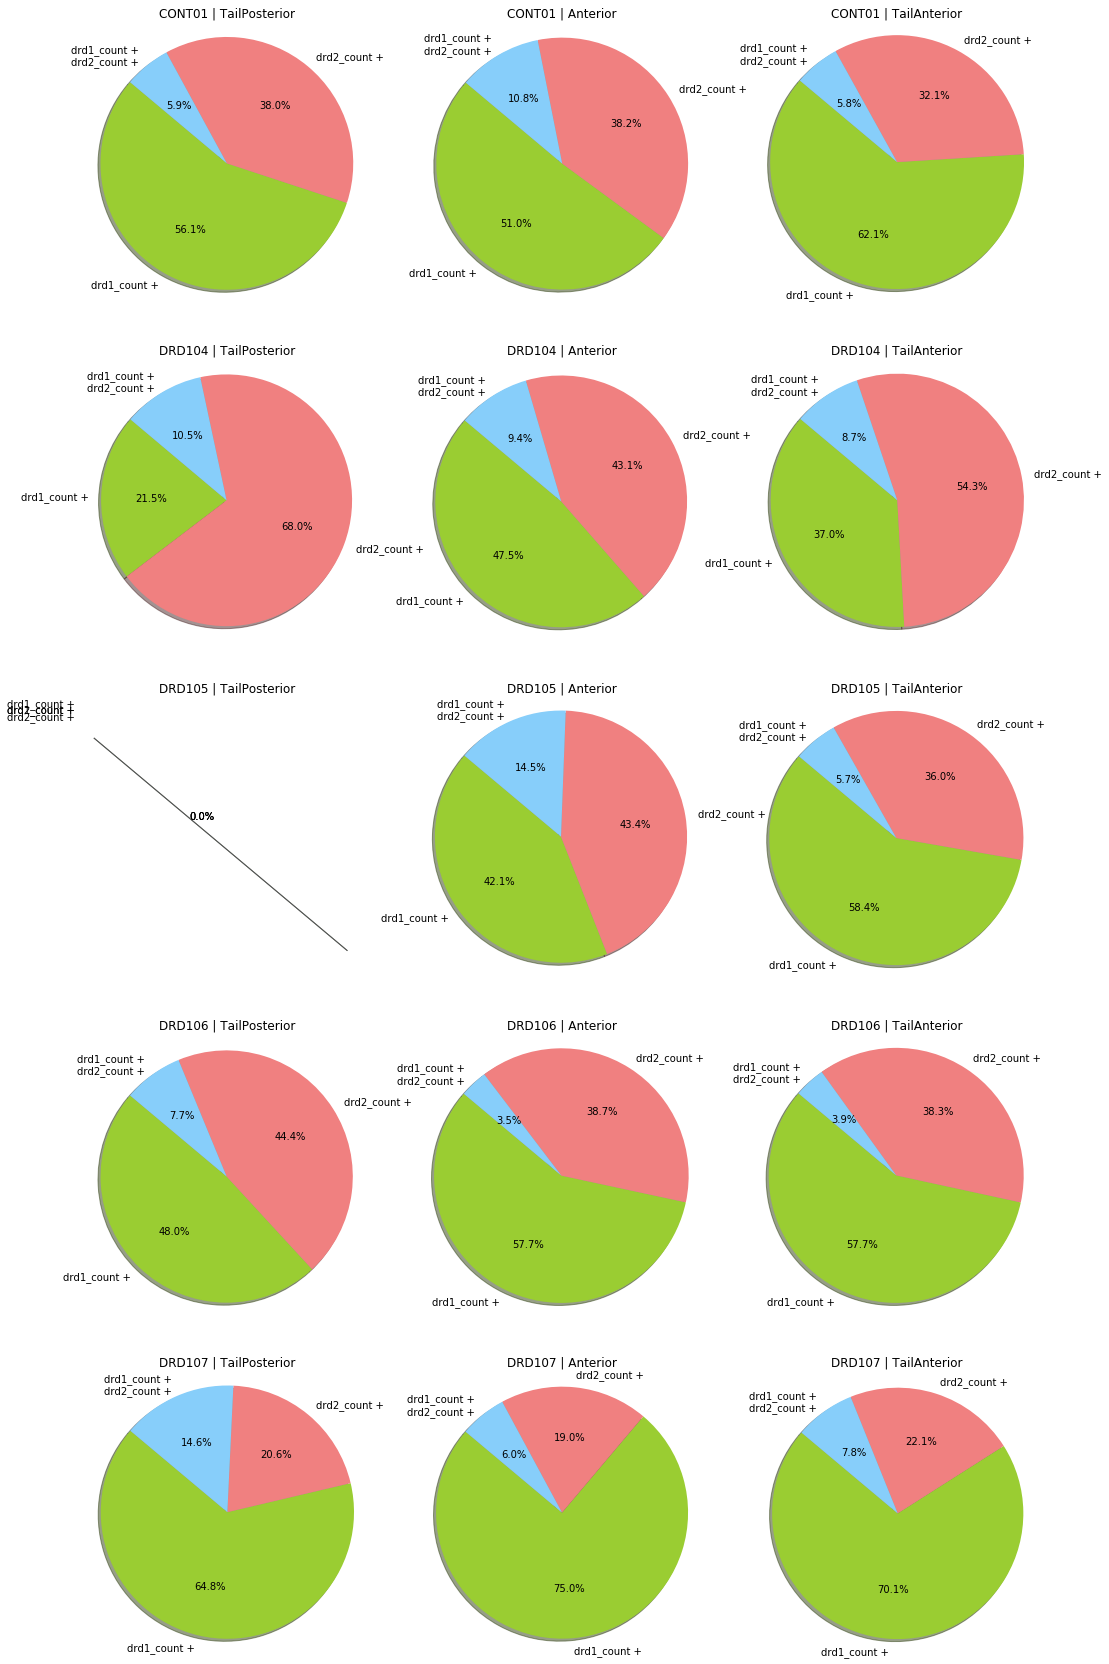

In [11]:
# plot a pie chart per mouse and per region
cutoff = 1
mice = df.AnimalID.unique()
regions = df.AP.unique()
fig, axs = plt.subplots(ncols=len(regions), nrows=len(mice), figsize=(17,30))
#axs = axs.ravel()

for i, mouse in enumerate(mice):
    dfm = df[df.AnimalID == mouse]
    for j, region in enumerate(regions):
        dfmr = dfm[dfm.AP == region]
        plot_utils.plot_pie(data_frame=dfmr, column_names=channels, cutoff=cutoff, ax=axs[i, j])
        axs[i, j].set_title(mouse + ' | ' + region)
plt.show()

In [12]:
# Find the density of d1 cells / percentage of cells of total
df['d1_above_thr'] = df.drd1_count > cutoff

In [13]:
df.columns

Index(['AnimalID', 'ExperimentalCondition', 'Slide', 'Slice', 'Side', 'AP',
       'ROI', 'ObjectNumber', 'drd2_count', 'drd1_count', 'Location_Center_X',
       'Location_Center_Y', 'PathName_Channel1', 'PathName_Channel2',
       'PathName_Channel3', 'd1_above_thr'],
      dtype='object')

In [14]:
# get the reproducibility (mean +/s std) of these measures checking every manual ROI
dfg = df.groupby(['AnimalID', 'AP', 'Slide', 'Slice', 'Side', 'ExperimentalCondition']).mean().dropna()

In [15]:
dfg = dfg.reset_index()

In [16]:
dfg

,AnimalID,AP,Slide,Slice,Side,ExperimentalCondition,ObjectNumber,drd2_count,drd1_count,Location_Center_X,Location_Center_Y,d1_above_thr
0,CONT01,Anterior,3,0,L,control,64.648016,0.163175,0.367020,782.788666,802.272149,0.070988
1,CONT01,Anterior,3,0,R,control,61.725585,0.385832,0.015131,792.058148,794.542686,0.003439
2,CONT01,Anterior,3,1,L,control,61.358470,1.751040,2.226227,795.573060,807.761884,0.310507
3,CONT01,Anterior,3,1,R,control,57.935766,1.727737,2.342336,801.470634,799.367979,0.318248
4,CONT01,Anterior,3,3,L,control,66.212025,0.180606,0.726040,785.085292,794.524799,0.147830
...,...,...,...,...,...,...,...,...,...,...,...,...
64,DRD107,TailAnterior,15,3,R,DRD1KO,75.859518,0.327515,1.276808,789.395427,771.151157,0.242727
65,DRD107,TailPosterior,19,0,R,DRD1KO,82.576220,0.384146,1.746951,806.412352,797.812067,0.301829
66,DRD107,TailPosterior,19,1,R,DRD1KO,84.555887,0.655738,2.341282,822.760892,851.443960,0.332340
67,DRD107,TailPosterior,19,2,R,DRD1KO,85.014859,0.448737,1.918276,809.182828,781.269668,0.271917


In [17]:
# Create a unique identifier for every instance of measure (manual ROI)
def group_name(df):
    return '-'.join(df[['Slide', 'Slice', 'Side']])
dfg['manual_ROI'] = dfg.apply(group_name, axis=1)

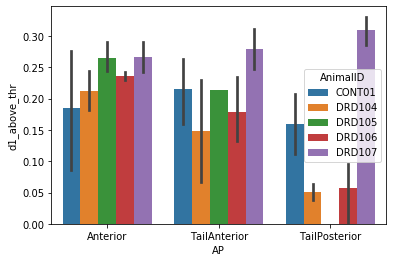

In [18]:
sns.barplot(data=dfg, x='AP', y='d1_above_thr', hue='AnimalID')

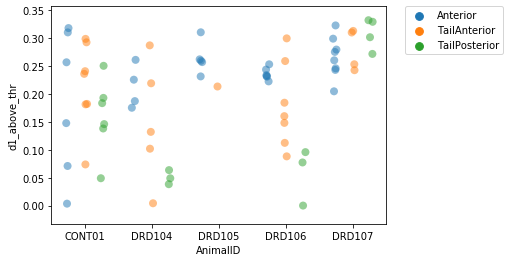

In [19]:
%matplotlib inline
sns.stripplot(data=dfg, x='AnimalID', y='d1_above_thr', hue='AP',
              dodge=True, jitter=True,
              alpha=.5, zorder=1, size=8)
plt.gca().legend(bbox_to_anchor=(1.35, 1), loc=0, borderaxespad=0.)
plt.show()

### Inspect closely the data
There is a lot of variability. See below why this seems to be the case

In [20]:
mouse = 'CONT01'
region = 'Anterior'
dfg[np.logical_and(dfg.AP==region, dfg.AnimalID==mouse)][['manual_ROI', 'd1_above_thr']]

,manual_ROI,d1_above_thr
0,3-0-L,0.070988
1,3-0-R,0.003439
2,3-1-L,0.310507
3,3-1-R,0.318248
4,3-3-L,0.147830
5,3-3-R,0.256893


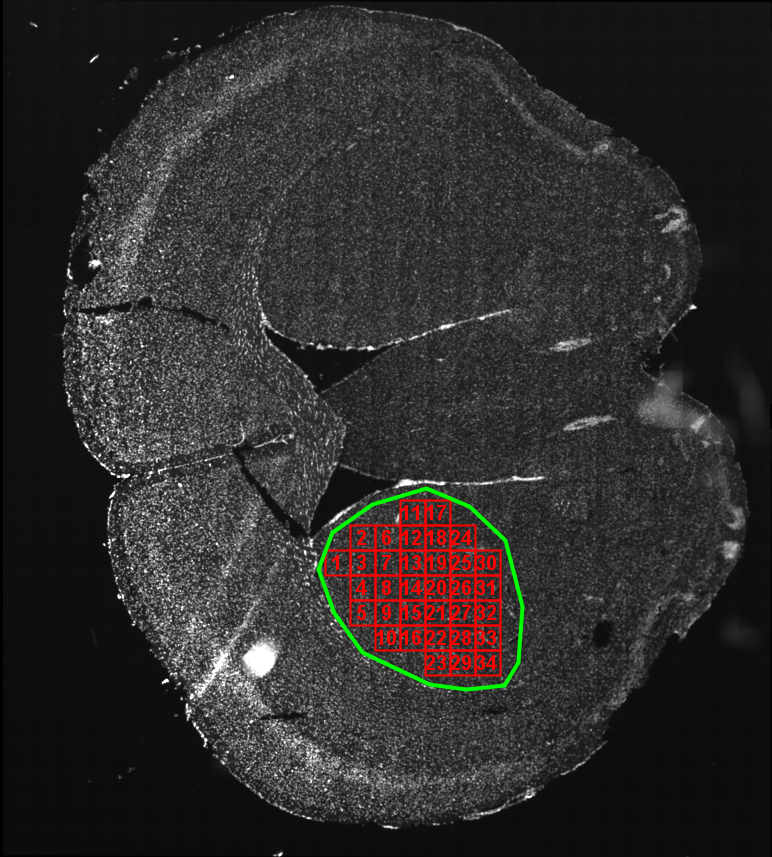

In [21]:
# plot the summary image
manroi = '3-3-L'
expcon = dfg[dfg.AnimalID==mouse].ExperimentalCondition.iloc[0]
corename = plot_utils.make_core_name(mouse, expcon, region, manroi)
sumdir = os.path.join(os.path.dirname(os.path.dirname(CPoutput_path)), 'ROIs', '000_Summary_of_ROIs')

img = Image.open(plot_utils.summary_image_name_maker(sumdir, corename))
img

<IPython.core.display.Javascript object>


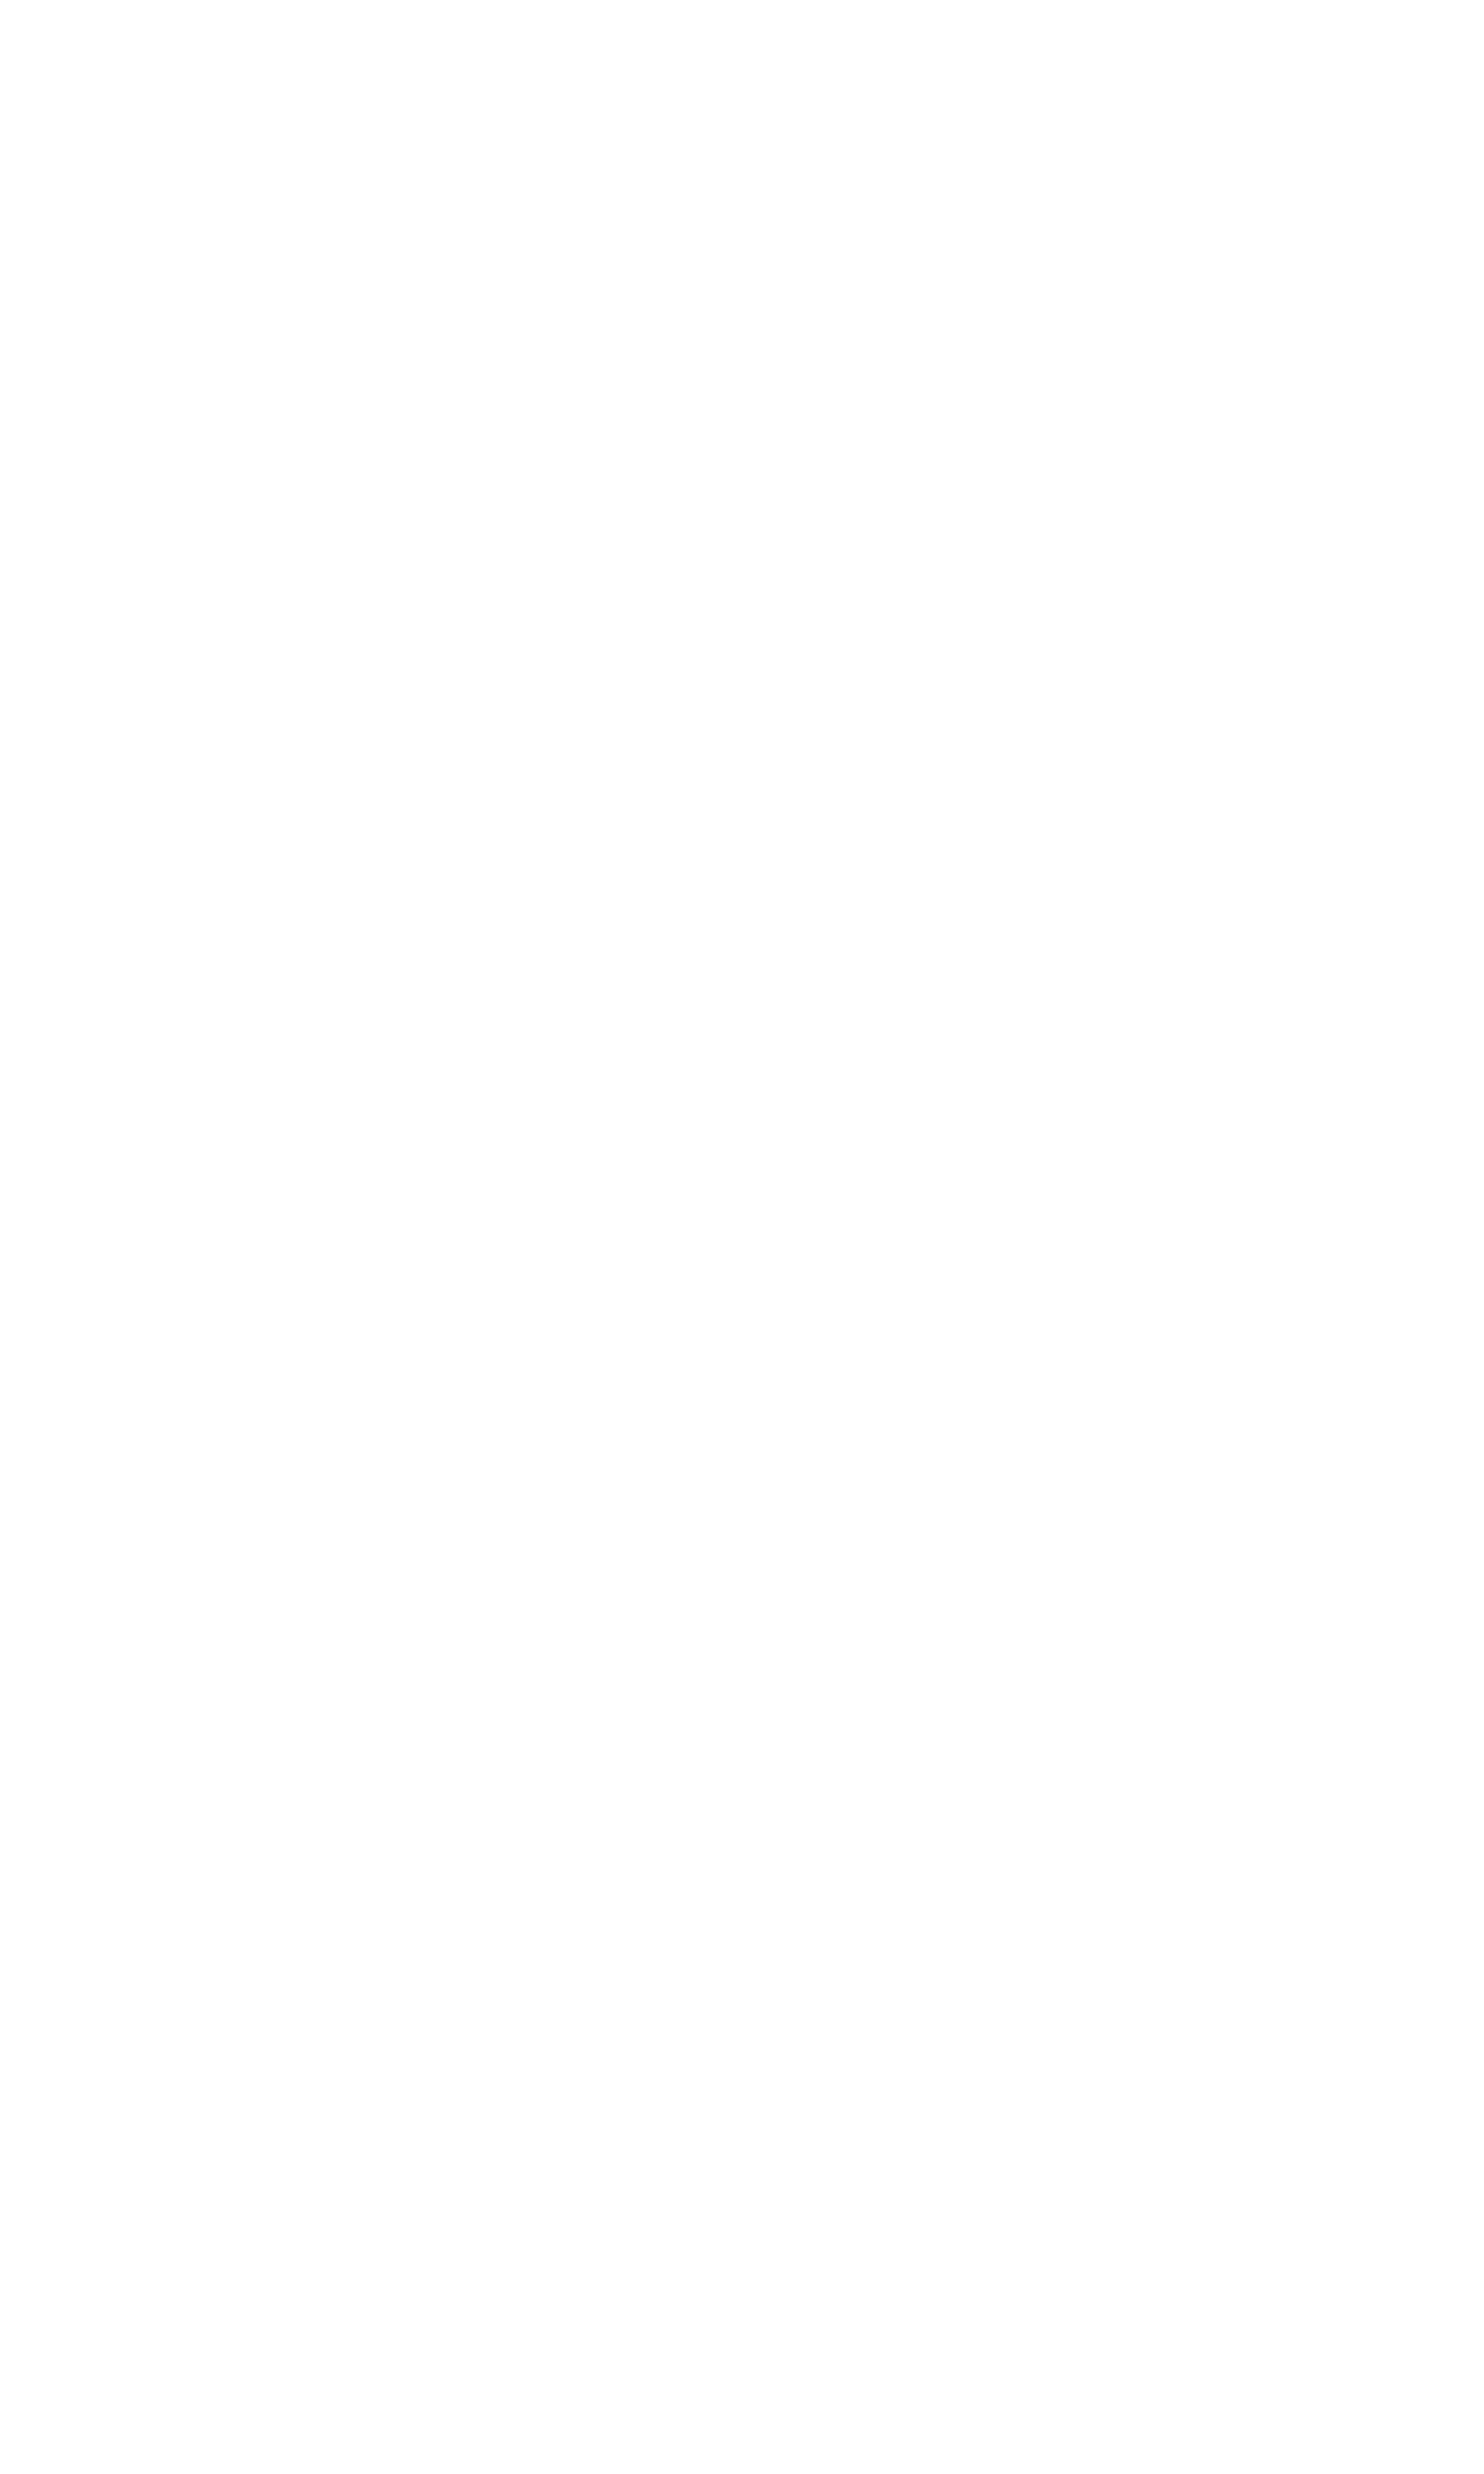

<IPython.core.display.Javascript object>


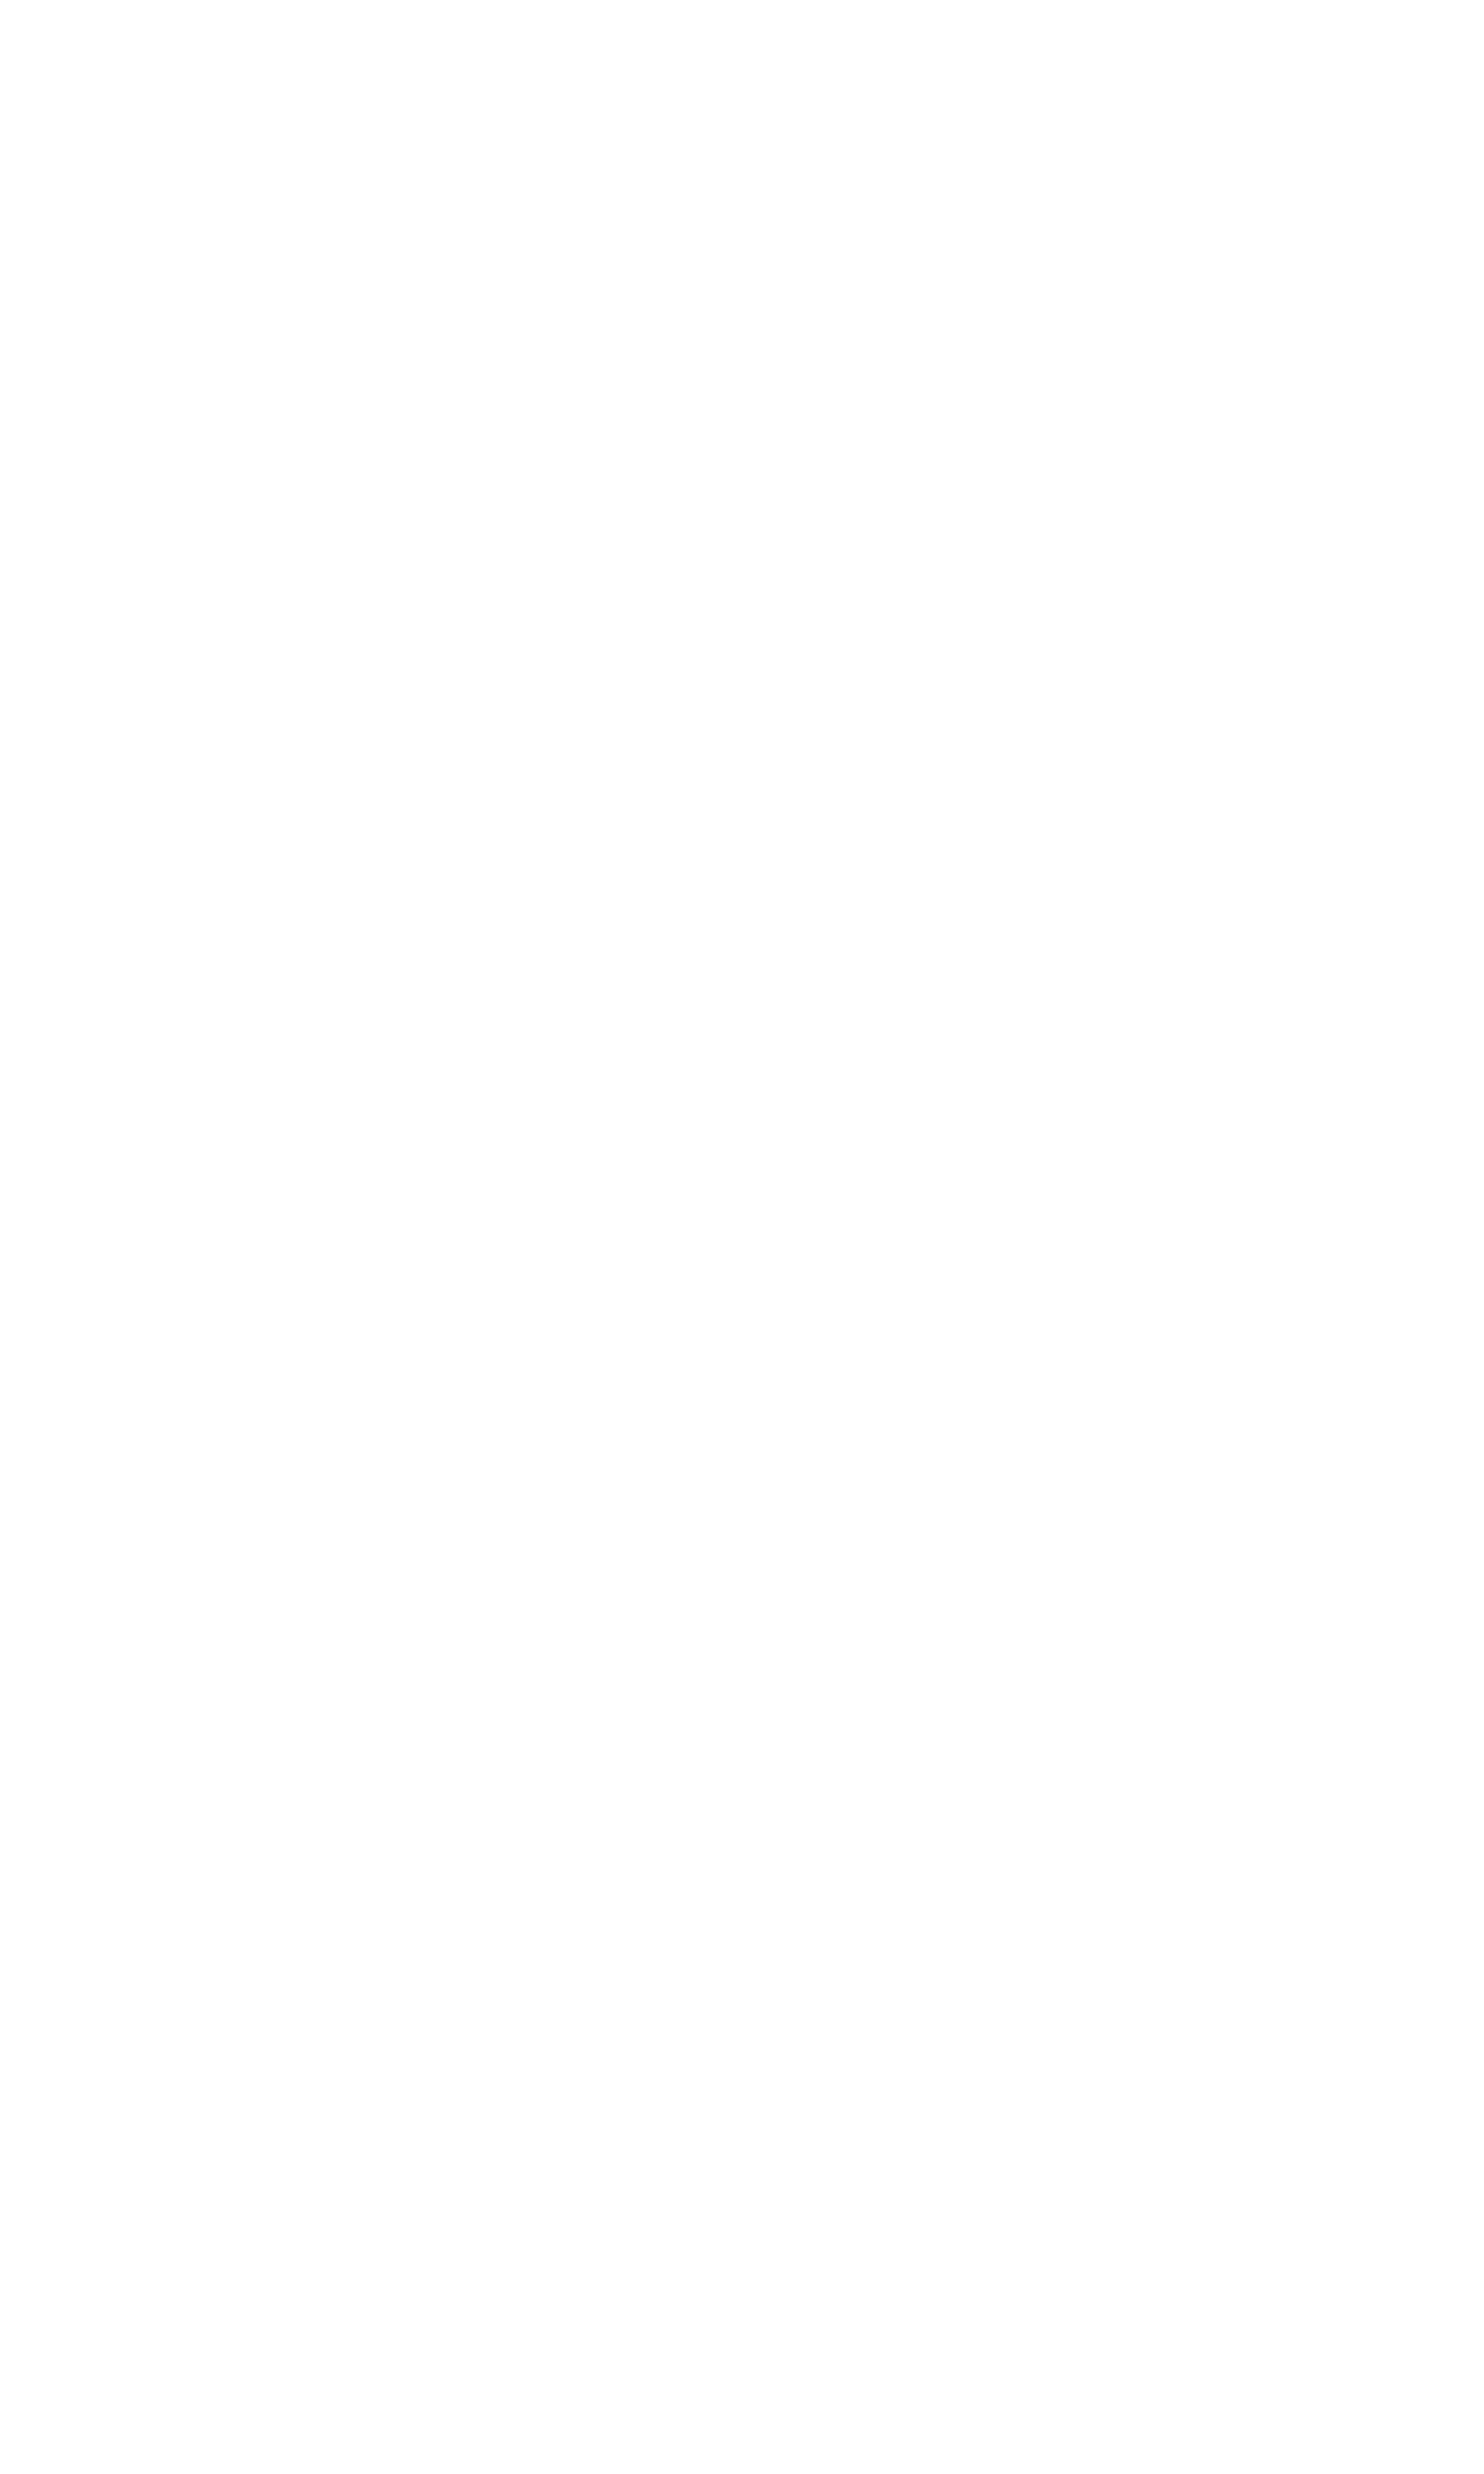

In [23]:
# inspect individual ROIs
# both original channels and result (4 images)
# plot 3 images at random

# specify where rois images are
roidir = os.path.join(os.path.dirname(os.path.dirname(CPoutput_path)), 'ROIs--Gce_processed')

# show 3 rois at random
%matplotlib nbagg
fig = plt.subplots(sharey=False, figsize=(12,20))
for i,roi in enumerate(plot_utils.get_random_rois(df, mouse, manroi, 3)):
    # specify the roi number
    roi_number = roi
    # get the path and open the image
    roi_paths = [plot_utils.get_roi_path(roidir, corename, roi_number, x) for x in [1, 2, 3]] # 1, 2, 3 are the channel names
    img_merge = plot_utils.create_merge_ROI(roi_paths)

    # get the Cell Profiler output image for this ROI
    img_cp = Image.open(plot_utils.get_cp_path(CPoutput_path, plot_utils.get_channel_name(corename, roi_number, 1)))

    # merge them
    img_cp = plot_utils.get_concat_h(img_merge, img_cp)
    
    plt.subplot(3, 1, i+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(plot_utils.get_channel_name(corename, roi_number, 1))
    plt.imshow(img_cp)

plt.show()

##### There is an out-of-focus problem
Very hard to detect even looking at DAPI in the high res. This is not fixable, and those images need to be removed from the dataset. This is not trivial though.
This is causing the big variability in the data, as the RNAscope dots are not getting detected properly.

Examples are DRD104 14, 0, L as an out of focus example, and 14, 1, L as a good one



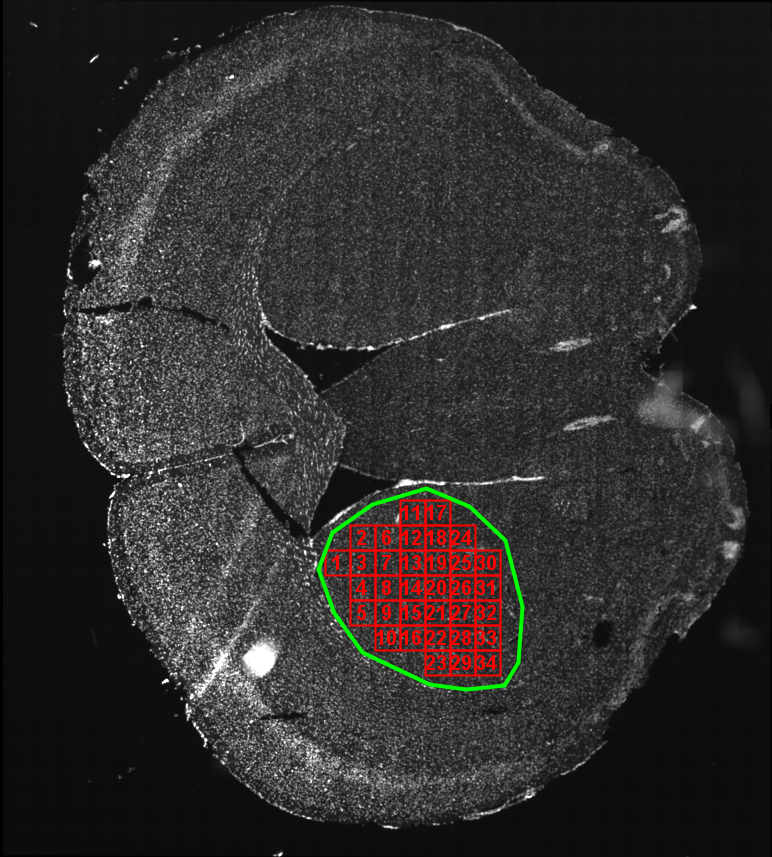

In [75]:
#CONT01 anterior 3-3-L might have a dorsal to ventral loss of focus
mouse = 'CONT01'
region = 'Anterior'
manroi = '3-3-L'
expcon = dfg[dfg.AnimalID==mouse].ExperimentalCondition.iloc[0]
corename = plot_utils.make_core_name(mouse, expcon, region, manroi)
sumdir = os.path.join(os.path.dirname(os.path.dirname(CPoutput_path)), 'ROIs', '000_Summary_of_ROIs')

img = Image.open(plot_utils.summary_image_name_maker(sumdir, corename))
img

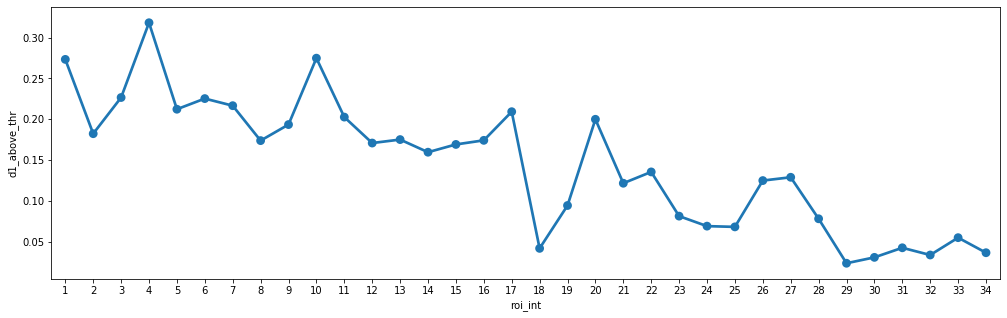

In [108]:
# As the ROIs are numbered, plot the amount of drd1 dots detected for each of this rois
conds = np.logical_and(df.AnimalID==mouse, df.AP==region)
conds = np.logical_and(conds, df.Slide==manroi.split('-')[0])
conds = np.logical_and(conds, df.Slice==manroi.split('-')[1])
conds = np.logical_and(conds, df.Side==manroi.split('-')[2])
dfroi = df[conds].groupby('ROI').mean().reset_index()
dfroi['roi_int'] = dfroi.ROI.astype(str).astype(int)
%matplotlib inline
fig, axs = plt.subplots(1, 1, figsize=(17, 5), facecolor='w', edgecolor='k')
sns.pointplot(data=dfroi, x='roi_int', y='d1_above_thr')
plt.show()

In [104]:
dfroi.ROI.astype(str).astype(int)

0      1
1     10
2     11
3     12
4     13
5     14
6     15
7     16
8     17
9     18
10    19
11     2
12    20
13    21
14    22
15    23
16    24
17    25
18    26
19    27
20    28
21    29
22     3
23    30
24    31
25    32
26    33
27    34
28     4
29     5
30     6
31     7
32     8
33     9
Name: ROI, dtype: int64

In [ ]:
# plot samples of these combinations
# original image name
Orig_image_name = 'OriginalOverlay.tiff'
img2 = Image.open(CPoutput_path+Orig_image_name)

NumOfSamples = 9
combToPlot = list(comb4)
if NumOfSamples > len(combToPlot):
    #update if needed
    NumOfSamples = len(combToPlot) 
NumOfSamples
fig = plt.subplots(sharey=False, figsize=(15,30))
for i in range(1,(NumOfSamples+1)): # make random without reinsertion
    # write here the cell number
    cellNum = combToPlot[i-1]
    test = plot_utils.see_object(cellNum,CPdata,img,img2,70)
    plt.subplot(NumOfSamples, 3, i)
    plt.grid(False)
    plt.axis('off')
    plt.title(cellNum)
    plt.imshow(test)


In [ ]:
# quantify the number of cells positive for the combinations of probes
# channels alone and combinations
# Bar Plot

# Venn Diagram?

In [ ]:
# pca plot from https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
pca = PCA(n_components=2)
pca_result = pca.fit_transform(CPdata[channels].values)
print ('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [ ]:
plt.scatter(pca_result[:,0],pca_result[:,1])

In [ ]:
PCA_df = pd.DataFrame(pca_result,columns=['pca1', 'pca2'])

chart = ggplot( PCA_df, aes(x='pca1', y='pca2') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("test")
chart

In [ ]:
# tsne plot
df_for_tsne = CPdata.copy()
#optional: do it only on the data that are included in the pie-chart categories:
df_for_tsne = CPdata.loc[frozenset(comb1.union(comb2,comb3,comb4))].copy()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_for_tsne[channels].values)

In [ ]:
df_tsne = df_for_tsne[channels].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

# color them according to the pie chart
df_tsne['label'] = 'none'
df_tsne.loc[ frozenset(comb1), ['label'] ] = labels[0]
df_tsne.loc[ frozenset(comb2), ['label'] ] = labels[1]
df_tsne.loc[ frozenset(comb3), ['label'] ] = labels[2]
df_tsne.loc[ frozenset(comb4), ['label'] ] = labels[3]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.4) \
        + ggtitle("tSNE dimensions colored by pir chart")
chart

In [ ]:
#FROM ANOTHER COPY OF THE NOTEBOOK
df_tsne = df_for_tsne[channels].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

# color them according to the pie chart
df_tsne['label'] = 'none'
df_tsne.loc[ frozenset(comb1), ['label'] ] = labels[0]
df_tsne.loc[ frozenset(comb2), ['label'] ] = labels[1]
df_tsne.loc[ frozenset(comb3), ['label'] ] = labels[2]
df_tsne.loc[ frozenset(comb4), ['label'] ] = labels[3]

# color = 'label'
df_tsne['lg_D1'] = np.log(df_tsne['Children_FinalDots_C4_Count'])
# a bunch of crap to convert -inf to zeros
idx = df_tsne['lg_D1'][np.isinf(df_tsne['lg_D1'])].index
newvector = df_tsne['lg_D1']
newvector.loc[idx] = 0
df_tsne['lg_D1'] = newvector
df_tsne['lg_D1']

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='lg_D1') ) \
        + geom_point(size=70,alpha=0.4) \
        + ggtitle("tSNE dimensions colored by pir chart")
chart

In [ ]:
# df_tsne = df_tsne[list(df_tsne.columns.values)[0:6]]
df_tsne.head()


In [ ]:
list(df_tsne["label_numeric"]).count(4)

In [ ]:
# plot in 3D the three axis
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(CPdata[channels[0]],CPdata[channels[1]],CPdata[channels[2]], alpha=0.1)
ax.set_xlabel(channellist[0])
ax.set_ylabel(channellist[1])
ax.set_zlabel(channellist[2])


plt.show()

In [ ]:
# plot the data to select cells
channel1 = 0
channel2 = 2
%matplotlib inline
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,7))
CPdata.plot.scatter(channels[channel1],channels[channel2], ax = ax)
ax3 = CPdata.plot(channels[channel1], channels[channel2], kind='scatter', ax = ax2)
CPdata[[channels[channel1],channels[channel2],'ObjectNumber']].apply(lambda x: ax3.text(*x),axis=1);

# create a density plot
# change labels

In [ ]:
# Show zoomed images (both the original and the processed image) depending on the object selected

# original image name
Orig_image_name = 'OriginalOverlay.tiff'
img2 = Image.open(CPoutput_path+Orig_image_name)

# write here the cell number
cellNum = 3920

test = plot_utils.see_object(cellNum,CPdata,img,img2,100)
test

In [ ]:
CPdata.shape[0]